In [97]:


 import tensorflow as tf
 import numpy as np
 import matplotlib.pyplot as plt
 #import tensorflow_datasets as tfds
 import cv2
 import os
 import shutil
 import xml.etree.ElementTree as ET

 #from PIL import image
 import albumentations as A

 from tensorflow.keras.layers import Resizing,Rescaling,InputLayer, Dense, Conv2D,MaxPooling2D
 from tensorflow.keras.layers import Permute,Embedding, LayerNormalization,MultiHeadAttention, Flatten, BatchNormalization, Input, Dropout, GlobalAveragePooling2D
 from tensorflow.keras.layers import Reshape,LeakyReLU,Add, Activation, RandomRotation,RandomFlip,RandomContrast
 from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
 from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy
 from tensorflow.keras.optimizers import Adam
 from tensorflow.keras.models import Model
 from tensorflow.keras.layers import Layer
 from tensorflow.keras.regularizers import L2,L1

 from tensorflow.train import BytesList, FloatList, Int64List
 from tensorflow.train import Example, Features, Feature
 import sklearn
 from sklearn.metrics import confusion_matrix, roc_curve
 import seaborn as sns

 from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

**Personal protective Equipment Dataset**

The annotated dataset of PPEs was downloaded from roboflow.

In [52]:
!pip install roboflow --user

from roboflow import Roboflow
rf = Roboflow(api_key="************")
project = rf.workspace("personal-protective-equipment").project("ppes-kaxsi")
dataset = project.version(8).download("voc")


**Data Preparation**

In [100]:

train_images ="/rwthfs/cluster.rz.rwth-aachen.de/home/tp135410/PPEs-8/train/"
val_images = "/rwthfs/cluster.rz.rwth-aachen.de/home/tp135410/PPEs-8/valid/"

classes = ['goggles','helmet', 'mask', 'no-suit', 'no_goggles', 'no_helmet', 'no_mask', 'no_shoes','shoes', 'suit', 'no_glove', 'glove' ]

# B: number of bounding box that each grid cell predicts
B = 2

num_classes = len(classes)

# Height and width of the input images
H,W = 224,224

# split_size: Number of grid cells in the image. Here: 224/32 = 7 . Hence, 7X7 grid cells each of size 32X32
split_size = H//32
n_epochs = 150

batch_size = 32



In [101]:
def preprocess_xml(filename):
  '''
  Takes in a list of filenames(xml) that contains information regarding the bounding box and classes of object in the image.
  This function converts the annotation from pascal_voc format i.e. (xmin, ymin, xmax, ymax, class) to a yolo format (xcenter, ycenter, width, height, class)
  Returns a tensor consisting of all the bounding boxes in the images whose filename is given in the parameter.
  '''
  tree = ET.parse(filename)
  root = tree.getroot()
  size_tree = root.find('size')
  height = float(size_tree.find('height').text)
  width = float(size_tree.find('width').text)
  bounding_boxes = []

  for object_tree in root.findall('object'):
    for bounding_box in object_tree.iter('bndbox'):
      xmin = (float(bounding_box.find('xmin').text))
      ymin = (float(bounding_box.find('ymin').text))
      xmax = (float(bounding_box.find('xmax').text))
      ymax = (float(bounding_box.find('ymax').text))

      break

    class_name = object_tree.find('name').text
    class_dict = {classes[i]:i for i in range(len(classes))}

    bounding_box = [
        (((xmin+xmax)/(2))-(1))/(width), (((ymin+ymax)/(2))-(1))/(height),
        (xmax-xmin)/(width), (ymax-ymin)/height, class_dict[class_name]]

    bounding_boxes.append(bounding_box)

  return tf.convert_to_tensor(bounding_boxes)

In [102]:

def generate_output(bounding_boxes):
  '''
  Takes the tensor of bounding boxes as input and converts the centre coordinates of the bounding box in the range (0-1) with reference to the
  cell in which the centre is present.
  Returns the output label which consists of the bounding box info with reference to the coordinate system of the cell which conains the centre of the box.
  '''

  output_label = np.zeros((split_size,split_size, num_classes+5))

  for b in range(len(bounding_boxes)):
    grid_x = bounding_boxes[b][0]*split_size
    grid_y =bounding_boxes[b][1]*split_size
    i = int(grid_x)
    j = int(grid_y)

    if(output_label[i,j,0]==0):
      output_label[i,j,0:5] = [1., grid_x%1, grid_y%1, bounding_boxes[b][2], bounding_boxes[b][3]]
      output_label[i,j,5+int(bounding_boxes[b][4])] = 1.

  return tf.convert_to_tensor(output_label, tf.float32)



In [104]:
# Creating lists of each image and annotation files for training and validation dataset
im_paths=[]
xml_paths=[]

val_im_paths=[]
val_xml_paths=[]


for i in os.listdir(train_images):
  if (i[-3:]=='jpg'):
    im_paths.append(train_images+i)
    xml_paths.append(train_images+i[:-3]+ 'xml')



for i in os.listdir(val_images):
  if(i[-3:]=='jpg'):
    val_im_paths.append(val_images+i)
    val_xml_paths.append(val_images+i[:-3]+ 'xml')



print(len(im_paths),len(xml_paths))
print(len(val_im_paths), len(val_xml_paths))

19419 19419
3570 3570


In [105]:
# Creating the train and validation dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((im_paths, xml_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_im_paths, val_xml_paths))

In [106]:
for i in train_dataset.take(2):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/rwthfs/cluster.rz.rwth-aachen.de/home/tp135410/PPEs-8/train/kp1049_jpg.rf.32ed0c7f6ff1425bec14e26a2885d999.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/rwthfs/cluster.rz.rwth-aachen.de/home/tp135410/PPEs-8/train/kp1049_jpg.rf.32ed0c7f6ff1425bec14e26a2885d999.xml'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/rwthfs/cluster.rz.rwth-aachen.de/home/tp135410/PPEs-8/train/packing1467_jpg.rf.6cd639caf395c7f58d63405abceef9af.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/rwthfs/cluster.rz.rwth-aachen.de/home/tp135410/PPEs-8/train/packing1467_jpg.rf.6cd639caf395c7f58d63405abceef9af.xml'>)


In [107]:
def get_imbboxes(im_path, xml_path):
  '''
  Takes in 2 parameters which holds the list of image paths and the annotation files path.
  Returns images with their corresponding annotation files

  '''

  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.cast(tf.image.resize(img, size = [H,W]), dtype = tf.float32)

  bboxes = tf.numpy_function(func = preprocess_xml, inp = [xml_path], Tout = tf.float32)

  return img, bboxes

In [108]:
train_dataset = train_dataset.map(get_imbboxes)
val_dataset = val_dataset.map(get_imbboxes)

**Data Augmentation**


Use of Albumentations to augment the images. Albumentations provides a way to transform images in different ways along with transforming the annotation files acordingly.Here, albumentation is used for transformations that can change the bounding boxes in the image.

In [109]:

transforms = A.Compose([
    A.Resize(H,W),
    A.RandomCrop(
          width=np.random.randint(int(0.9*W),W),
          height=np.random.randint(int(0.9*H),H), p=0.5),
    A.RandomScale(scale_limit=0.1, interpolation=cv2.INTER_LANCZOS4,p=0.5),
     A.HorizontalFlip(p=0.5,),
    A.Resize(H,W),

], bbox_params=A.BboxParams(format='yolo', ))

In [110]:
def aug_albument(image,bboxes):
  augmented=transforms(image=image,bboxes=bboxes)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["bboxes"],dtype=tf.float32)]


In [111]:

def process_data(image,bboxes):
    aug= tf.numpy_function(func=aug_albument, inp=[image,bboxes], Tout=(tf.float32,tf.float32))
    
    #aug[1][...,2]=tf.clip_by_value(aug[1][...,2], 0.0, 1.0)
    return aug[0],aug[1]

In [112]:
train_dataset = train_dataset.map(process_data)

**Augmentations that changes the image features like brightness, contrast,etc. that does not change the annotation files.**

In [113]:
def preprocess_augment_train(img,y):
  img = tf.image.random_brightness(img, max_delta=50.)
  img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
  img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
  #img = tf.image.random_hue(img, max_delta=0.5 )
  img = tf.clip_by_value(img, 0, 255)
  labels=tf.numpy_function(func=generate_output, inp=[y], Tout=(tf.float32))
  return img,labels

**Preprocessing  the validation dataset.**

Resizing the images to  dimensions as required by the model.

In [114]:
def preprocess_val(img,y):
  img = tf.cast(tf.image.resize(img, size=[H, W]), dtype=tf.float32)

  labels=tf.numpy_function(func=generate_output, inp=[y], Tout=(tf.float32))
  return img,labels

In [115]:
#def preprocess(img, bboxes):
  #labels = tf.numpy_function(func = generate_output, inp=[bboxes], Tout = (tf.float32))
  #return img,labels

In [116]:
train_dataset = train_dataset.map(preprocess_augment_train)
val_dataset = val_dataset.map(preprocess_val)

In [117]:
train_dataset = (
    train_dataset.batch(batch_size = batch_size).
    prefetch(tf.data.AUTOTUNE)
)

In [118]:
val_dataset = (
    val_dataset.batch(batch_size = batch_size).
    prefetch(tf.data.AUTOTUNE)
)

In [119]:
NUM_FILTERS= 512
# OUTPUT_DIM: size of the vector that defines the bounding box for each grid cell
OUTPUT_DIM = num_classes + 5*B

**Transfer Learning**

Using the already trained resnet50 model for extracting features that would be useful for classification of objects in the images. This is used in place of initial few layers of the model that would otherwise be designed to extract features for classification of objects in the images.

In [120]:
base_model = tf.keras.applications.resnet50.ResNet50(
    weights = 'imagenet',
    input_shape = (H, W, 3),
    include_top = False
)

base_model.trainable = False

**YOLO Model**

This model was created by following the reasearch paper "You Only Look Once: Unified, Real-Time Object Detection" by Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi.


https://doi.org/10.48550/arXiv.1506.02640

The model was created to overcome the limitations of other detection model that were slow in speed and hence, not reliable for real time detection. YOLO provides comparable accuracy to Faster R-CNN model while also increasing the sped of detection.

In [121]:
model=tf.keras.Sequential([
  base_model,
  Conv2D(NUM_FILTERS,(3,3), padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  LeakyReLU(alpha=0.1),

  Flatten(),

  Dense(NUM_FILTERS,kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Dropout(0.5),

  Dense(split_size*split_size*OUTPUT_DIM,activation='sigmoid'),

  Reshape((split_size,split_size,OUTPUT_DIM)),
])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 512)         9437696   
                                                                 
 batch_normalization_8 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 7, 7, 512)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 batch_normalization_9 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                      

In [122]:
def compute_iou(boxes1, boxes2):
  '''
  Takes 2 parameters that contains the bounding box prediction for each cell in the grid . Each cell predicts two bounding boxes.
  Returns the intersection over union for each pair of the predictons.
  '''
  boxes1_t = tf.stack([boxes1[...,0]- boxes1[..., 2]/2.0,
                       boxes1[..., 1] - boxes1[...,3]/2.0,
                       boxes1[...,0] + boxes1[...,2]/2.0,
                       boxes1[...,1] + boxes1[...,3]/2.0],
                      axis = -1
                      )

  boxes2_t = tf.stack([boxes2[...,0]- boxes2[..., 2]/2.0,
                       boxes2[..., 1] - boxes2[...,3]/2.0,
                       boxes2[...,0] + boxes2[...,2]/2.0,
                       boxes2[...,1] + boxes2[...,3]/2.0],
                      axis = -1
                      )

  lu = tf.maximum(boxes1_t[...,:2],boxes2_t[...,:2])
  rd = tf.minimum(boxes1_t[...,2:],boxes2_t[...,2:])

  intersection = tf.maximum(0.0, rd-lu)
  inter_square = intersection[..., 0]*intersection[...,1]

  square1 = boxes1[..., 2] * boxes1[...,3]
  square2 = boxes2[..., 2] * boxes2[..., 3]

  union_square = tf.maximum(square1+square2 - inter_square, 1e-10)

  return tf.clip_by_value(inter_square/union_square, 0.0, 1.0)

In [123]:
def difference(x,y):
  return tf.reduce_sum(tf.square(y-x))

**YOLO Loss**

The Yolo Loss is as described in the paper is divided into four components:
1. Object Loss:Calculated for grid cells which contains the centre of objects.
2. No object Loss: Calculated for grid cells which do not contain centres of any objects
3.Object class loss: Calculates the class loss by comparing the true class and predicted class
4.Object Bounding box loss: Calculated for grid cells containing the centres of objects in the image
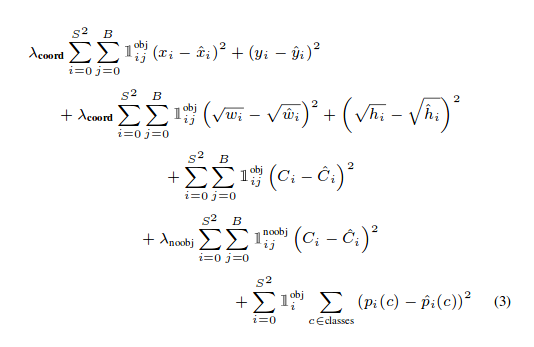

In [124]:

def yolo_loss(y_true, y_pred):
  '''
  Takes in the true labels and the predicted labels and returns the loss as described in the paper.
  '''
  target =  y_true[...,0]

  ##### Object loss
  y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
  y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))

  #print(tf.where(target[:]==1))
  #print(y_pred_extract)
  #print(y_target_extract)

  rescaler = tf.where(target[:]==1)*32
  #print('r:',rescaler)
  upscaler_1 = tf.concat([rescaler[:, 1:], tf.zeros([len(rescaler),2], dtype = tf.int64)], axis = -1)



  target_upscaler_2 = tf.repeat([[32., 32., 224., 224.]],
                                repeats = [len(rescaler)], axis=0)*tf.cast(y_target_extract[...,1:5], dtype=tf.float32)



  pred_1_upscaler_2 = tf.repeat([[32., 32., 224., 224.]],
                                repeats = [len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,1:5], dtype=tf.float32)


  pred_2_upscaler_2 = tf.repeat([[32., 32., 224., 224.]],
                                repeats = [len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,6:10], dtype=tf.float32)

  target_orig = tf.cast(upscaler_1, dtype = tf.float32)+ target_upscaler_2
  pred_1_orig= tf.cast(upscaler_1, dtype = tf.float32)+ pred_1_upscaler_2
  pred_2_orig= tf.cast(upscaler_1, dtype = tf.float32)+ pred_2_upscaler_2

  mask = tf.cast(tf.math.greater(compute_iou(target_orig, pred_2_orig),
                                 compute_iou(target_orig, pred_1_orig), ), dtype = tf.int32)

  y_pred_joined = tf.transpose(tf.concat([tf.expand_dims(y_pred_extract[...,0], axis=0),
                                          tf.expand_dims(y_pred_extract[...,5], axis=0)], axis =0))

  obj_pred = tf.gather_nd(y_pred_joined, tf.stack([tf.range(len(rescaler)), mask], axis=-1))

  object_loss = difference(tf.cast(obj_pred,dtype=tf.float32),
                           tf.cast(tf.ones([len(rescaler)]), dtype=tf.float32))
  #print( ' first:',compute_iou(target_orig, pred_1_orig))
  #print( ' second:',compute_iou(target_orig, pred_2_orig))
  #print('mas:', mask)
  #print('y_pred_j:',y_pred_joined )
  #print('obj_pred_j:',obj_pred )
  #tf.print('object_loss:', object_loss)



  ######## No Object loss
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5],tf.where(target[:]==0))
  y_target_extract = tf.zeros(len(y_pred_extract))

  no_object_loss_1 = difference(tf.cast(y_pred_extract[...,0], dtype=tf.float32),
                                tf.cast(y_target_extract, dtype = tf.float32))

  no_object_loss_2 = difference(tf.cast(y_pred_extract[...,5], dtype=tf.float32),
                                tf.cast(y_target_extract, dtype=tf.float32))


  no_object_loss = no_object_loss_1 + no_object_loss_2


  #print('a:',y_pred_extract)
  #tf.print("no_object_loss:", no_object_loss)



  ##### Object class loss
  y_pred_extract = tf.gather_nd(y_pred[...,10:], tf.where(target[:]==1))
  class_extract = tf.gather_nd(y_true[...,5:], tf.where(target[:]==1))

  #print('len:',tf.shape(class_extract))
  #print('len_p:', tf.shape(y_pred_extract))
  class_loss = difference(tf.cast(y_pred_extract, dtype=tf.float32),
                          tf.cast(class_extract, dtype = tf.float32))

  #print(class_loss)



  ######## Object Bounding box loss

  y_pred_extract = tf.gather_nd(y_pred[..., 0:B*5], tf.where(target[:]==1))
  #print('b:',y_pred_extract[...,1:3])
  #print('c:', )
  centre_joined = tf.stack([y_pred_extract[..., 1:3],y_pred_extract[..., 6:8]], axis=1)

  centre_pred = tf.gather_nd(centre_joined, tf.stack([tf.range(len(rescaler)),mask], axis=-1))
  centre_target = tf.gather_nd(y_true[...,1:3], tf.where(target[:]==1))

  centre_loss = difference(tf.cast(centre_pred, dtype = tf.float32), tf.cast(centre_target, dtype=tf.float32))

  size_joined = tf.stack([y_pred_extract[...,3:5], y_pred_extract[...,8:10]], axis=1)

  size_pred = tf.gather_nd(size_joined,tf.stack([tf.range(len(rescaler)), mask], axis=-1))
  size_target = tf.gather_nd(y_true[...,3:5], tf.where(target[:]==1))

  size_loss = difference(tf.cast(tf.math.sqrt(tf.math.abs(size_pred)), dtype=tf.float32), tf.cast(tf.math.sqrt(tf.math.abs(size_target)), dtype=tf.float32 ))
  box_loss = centre_loss + size_loss

  lambda_coord = 5.0
  lambda_no_obj = 0.5

  loss = object_loss+ (lambda_no_obj * no_object_loss) +lambda_coord*box_loss + class_loss
  #tf.print(loss)

  return loss


tf.Tensor([ 1  7  7 17], shape=(4,), dtype=int32)


<tf.Tensor: shape=(), dtype=float32, numpy=47.634438>

**Custom Callbacks**

Callbacks to monitor the validation loss to save the best weights and a learning rate scheduler to schedule the learning rates for different epochs.

In [125]:
checkpoint_path = '/your/fie/path'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_path,
    save_weights = True,
    monitor= 'val_loss',
    mode= 'min',
    save_best_only = True
)

In [126]:
def scheduler(epoch,lr):
  if epoch<40:
    return 1e-3
  elif epoch>=40 and epoch<80:
    return 5e-4
  else:
    return 1e-4

In [127]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

**Compiling the model**

In [128]:
model.compile(
    loss = yolo_loss,
    optimizer = Adam(1e-3),
    #run_eagerly = True
)

**Load the drive to save the weights**

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Model Training**

In [130]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    verbose = 1,
    epochs =150,
    callbacks = [lr_callback, callback],

)

Epoch 1/150
607/607 [==============================] - 148s 244ms/step - loss: 99.4813 - val_loss: 132.3238 - lr: 0.0010
Epoch 2/150
607/607 [==============================] - 115s 190ms/step - loss: 79.4431 - val_loss: 137.7342 - lr: 0.0010
Epoch 3/150
607/607 [==============================] - 118s 194ms/step - loss: 69.5299 - val_loss: 133.8933 - lr: 0.0010
Epoch 4/150
607/607 [==============================] - 123s 203ms/step - loss: 62.7687 - val_loss: 130.4046 - lr: 0.0010
Epoch 5/150
607/607 [==============================] - 122s 201ms/step - loss: 57.9232 - val_loss: 128.8280 - lr: 0.0010
Epoch 6/150
607/607 [==============================] - 122s 202ms/step - loss: 53.9852 - val_loss: 122.4898 - lr: 0.0010
Epoch 7/150
607/607 [==============================] - 120s 198ms/step - loss: 50.4335 - val_loss: 120.1106 - lr: 0.0010
Epoch 8/150
607/607 [==============================] - 120s 197ms/step - loss: 47.6029 - val_loss: 123.8593 - lr: 0.0010
Epoch 9/150
607/607 [===========

**Testing the model**

In [136]:

model.load_weights(checkpoint_path)

In [29]:

!mkdir outputs/


In [137]:
Test_path='/rwthfs/cluster.rz.rwth-aachen.de/home/tp135410/PPEs-8/test/'

In [146]:
def model_test(filename):
    ''' 
    Takes in the list of filepath of images to be tested and predicts their corresponding classes and bounding box.
    Performs non-max suppression to result in only one bounding box per object.
    Returns image with their object detection predictions.
    
    '''
  try:
    test_path=Test_path+filename

    #print(test_path)

    img=cv2.resize(cv2.imread(test_path),(224,224))

    image=tf.io.decode_jpeg(tf.io.read_file(test_path))
    image=tf.image.resize(image, [H,W])

    output=model.predict(np.expand_dims(image, axis = 0))

    THRESH=.50

    object_positions=tf.concat(
        [tf.where(output[...,0]>=THRESH),tf.where(output[...,5]>=THRESH)],axis=0)
    #print(object_positions)
    selected_output=tf.gather_nd(output,object_positions)
   # print(selected_output)
    final_boxes=[]
    final_scores=[]

    for i,pos in enumerate(object_positions):
      for j in range(2):
        if selected_output[i][j*5]>THRESH:
          output_box=tf.cast(output[pos[0]][pos[1]][pos[2]][(j*5)+1:(j*5)+5],dtype=tf.float32)

          x_centre=(tf.cast(pos[1],dtype=tf.float32)+output_box[0])*32
          y_centre=(tf.cast(pos[2],dtype=tf.float32)+output_box[1])*32

          x_width,y_height=tf.math.abs(H*output_box[2]),tf.math.abs(W*output_box[3])

          x_min,y_min=int(x_centre-(x_width/2)),int(y_centre-(y_height/2))
          x_max,y_max=int(x_centre+(x_width/2)),int(y_centre+(y_height/2))

          if(x_min<=0):x_min=0
          if(y_min<=0):y_min=0
          if(x_max>=W):x_max=W
          if(y_max>=H):y_max=H
          final_boxes.append(
              [x_min,y_min,x_max,y_max,
              str(classes[tf.argmax(selected_output[...,10:],axis=-1)[i]])])
          final_scores.append(selected_output[i][j*5])
    #print(final_scores)
    #print('finalboxes',final_boxes)
    final_boxes=np.array(final_boxes)

    object_classes=final_boxes[...,4]
    nms_boxes=final_boxes[...,0:4]
    
    # NON-MAX SUPPRESSION
    nms_output=tf.image.non_max_suppression(
        nms_boxes,final_scores,max_output_size=100,iou_threshold=0.5,
        score_threshold=float('-inf')
    )
    #print(nms_output)

    
    for i in nms_output:
      cv2.rectangle(
          img,
          (int(final_boxes[i][0]),int(final_boxes[i][1])),
          (int(final_boxes[i][2]),int(final_boxes[i][3])),(0,0,255),1)
      cv2.putText(
          img,
          final_boxes[i][-1],
          (int(final_boxes[i][0]),int(final_boxes[i][1])+15),
          cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(2,225,155),1
          )

    cv2.imwrite('/rwthfs/cluster.rz.rwth-aachen.de/home/tp135410/PPEs-8/outputs/'+filename[:-4]+'_det'+'.jpg',cv2.resize(img,(224,224)))
  except:
    print("NO object found !!!")


In [147]:

for filename in os.listdir(Test_path):
  if(filename[-3:]=='jpg'):
    model_test(filename)

1/1 [==============================] - 0s 20ms/step
NO object found !!!
1/1 [==============================] - 0s 18ms/step
NO object found !!!
1/1 [==============================] - 0s 18ms/step
NO object found !!!
1/1 [==============================] - 0s 18ms/step
NO object found !!!
1/1 [==============================] - 0s 18ms/step
NO object found !!!
1/1 [==============================] - 0s 18ms/step
NO object found !!!
1/1 [==============================] - 0s 18ms/step
NO object found !!!
1/1 [==============================] - 0s 18ms/step
NO object found !!!
1/1 [==============================] - 0s 19ms/step
NO object found !!!
1/1 [==============================] - 0s 18ms/step
NO object found !!!
1/1 [==============================] - 0s 18ms/step
NO object found !!!
1/1 [==============================] - 0s 19ms/step
NO object found !!!
1/1 [==============================] - 0s 18ms/step
NO object found !!!
1/1 [==============================] - 0s 19ms/step
NO object fo